<a href="https://colab.research.google.com/github/SpirinEgor/HSE.Deep_Unsupervised_Learning/blob/hw10/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
! nvidia-smi

Tue Feb  8 21:26:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    58W / 149W |    824MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw10

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 953, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 953 (delta 236), reused 254 (delta 135), pack-reused 525
Receiving objects: 100% (953/953), 75.68 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (468/468), done.
/content/HSE.Deep_Unsupervised_Learning/HSE.Deep_Unsupervised_Learning
Branch 'hw10' set up to track remote branch 'hw10' from 'origin'.
Switched to a new branch 'hw10'


In [12]:
! pip install -q -r requirements.txt

In [13]:
! git pull

Already up to date.


In [1]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [2]:
from random import sample

import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from context_encoder.datasets import MaskedImageDataset, RotationDataset
from context_encoder.restore_mask_model import ContextEncoder
from context_encoder.rotation_predict_model import RotationPredictModel
from utils.hw10_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [19]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    train_dataset = MaskedImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    context_encoder = ContextEncoder(128, device)
    mse_losses, adv_losses = context_encoder.train(train_dataloader, n_epochs=10, lr=1e-3)

    sample_idx = sample(range(len(train_dataset)), 10)

    masked = torch.stack([train_dataset[i][0] for i in sample_idx]).to(device)
    ground_truth = torch.stack([train_data[i][0] for i in sample_idx]).to(device)

    context_encoder.eval()
    with torch.no_grad():
        embeddings = context_encoder.encoder(masked)
        rec_patches = context_encoder.decoder(embeddings)
        rec_patches = context_encoder.to_mnist(rec_patches)

    mask = train_dataset.get_mask()
    reconstructed = []
    for i, pos in enumerate(sample_idx):
        image = train_dataset[pos][0].to(device)
        image[mask] = rec_patches[i].reshape(-1)
        reconstructed.append(image)
    reconstructed = torch.stack(reconstructed)

    res = torch.cat([masked, reconstructed, ground_truth]).detach().cpu().numpy()
    return mse_losses, adv_losses, res

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

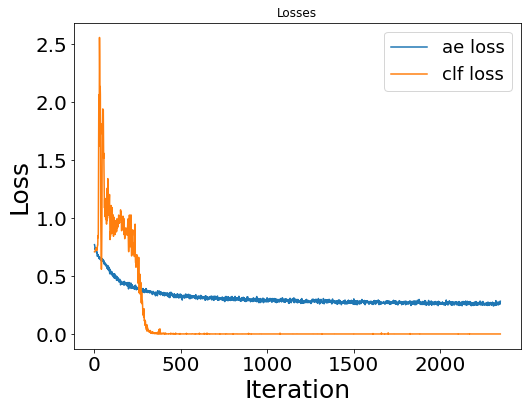

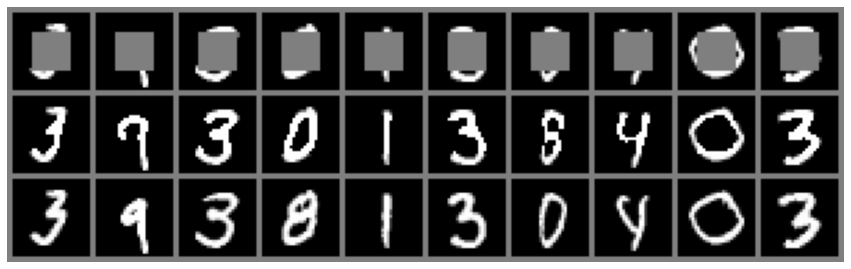

In [20]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [15]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    train_dataset = RotationDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    model = RotationPredictModel(10, 4, device)
    return model.fit(train_dataloader, 1, 1e-3)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

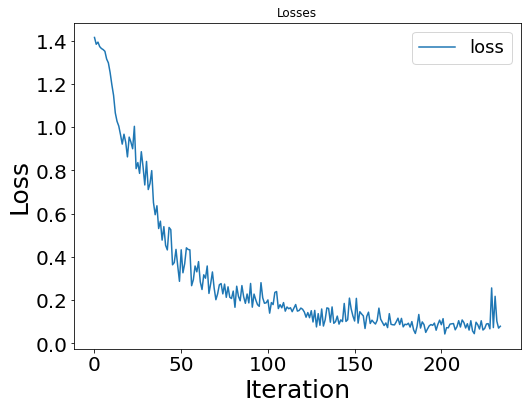

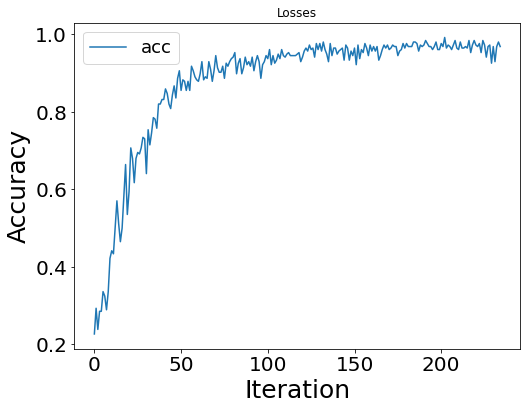

In [16]:
q2_results(q2)